# Reproducing Villena-Gonzalez CDA Study (2019) - L vs R

In [1]:
import numpy as np
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum
 
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [2]:
#==================================================================
# General Variables
#==================================================================
## Organize Triggers
triggers = dict();

triggers['1'] = [10,11,12,13] 
triggers['2'] = [20,21,22,23]
triggers['4'] = [40,41,42,43]

triggers['left'] = [11,12,21,22,41,42]
triggers['right'] = [10,13,20,23,40,43]

triggers['good'] = [60]
triggers['bad'] = [61]
# --------------------------

# Labels
conds = ['1', '2', '4']
sides = ['left', 'right']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
chan_left =  ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']

# Epoch information
epoch_length = 1.2
epoch_tmin = -0.4
baseline_corr = (-0.4, -0.2)

# CDA main variable!
cda_dict = dict()
epochs_dict_all = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
#directory_path = 'D:\\CLNT\\Data\\Open Datasets\\Villena-Gonzalez 2019\\Data\\'
directory_path = '/Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/'
sep = '/'

for filepath in glob.iglob(directory_path + '*.bdf'):
    filename = filepath[filepath.rfind(sep)+1:]
    print('Processing: ' + filename + '...')
   
    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_bdf(filepath, preload=True)

    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    # Keep only EEG channels and reference
    #raw = raw.rename_channels({'EXG7':'A1', 'EXG8': 'A2'})
    raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG4','EXG5','EXG6'])
    raw = raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'])
    raw = raw.set_channel_types({'EXG7': 'misc', 'EXG8': 'misc'})
    
    # Set Electrodes Locations
    montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(montage)

    # Resample
    preproc = raw.resample(1024)

    # Filter
    preproc = preproc.filter(.1, 20., fir_design='firwin', skip_by_annotation='edge')

    # Events
    events = find_events(preproc)
        
    # Chan Pairs
    chan_pairs = ['{}-{}'.format(chan_right[i], chan_left[i]) for i, chan in enumerate(chan_right)]

    for i, chan in enumerate(chan_right):
        preproc = mne.set_bipolar_reference(preproc, anode=[str(chan_right[i])], cathode=[str(chan_left[i])])
        #new_cda = cur_bipolar_epochs.pick_channels(['{}-{}'.format(chan_right[i], chan_left[i])]).average().data

    preproc = preproc.pick_channels(chan_pairs)
    
    # Plot (visual check)
    #preproct.plot...
    
    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    specific_events = get_specific_events(events, conds, sides, perfs, triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    epochs_dict_all[filename] = epochs_dict
    
    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    #report = fill_report(report, filename, specific_events)
    #report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)
    
    # ------------------------
    # 5. -- CDA --
    # ------------------------
    #cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)


# Add time points to CDA for later use.
cda_dict['times'] = epochs_dict['2']['left']['good'].times

# Print report
subreport = get_report(report, ['1','2', '4'], ['left','right'], ['good', 'bad'], [])
report

Processing: LS150419.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/LS150419.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 790527  =      0.000 ...   386.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65577 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
380 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65577 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
380 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
-------------------

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
384 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
384 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65791 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
381 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65791 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
381 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
383 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
383 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
380 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
380 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
376 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
376 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65791 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
371 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65791 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
371 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
381 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
381 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
368 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
368 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65791 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
383 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65791 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
383 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_44270/2531976098.py:51: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = read_raw_bdf(filepath, preload=True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1273 events found
Event IDs: [    1    10    11    12    13    20    21    22    23    30    31    32
    33    40    41    42    43    50    51    52    53    60    61    62
    63    64    65    66    67    68    69    70    71    72    73    74
    75    76    77    78    79    80    81 65536]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1273 events found
Event IDs: [    1    10    11    12    13    20    21    22    23    30    31    32
    33    40    41    42    43    50    51    52    53    60    61    62
    63    64    65    66    67    68    69    70    71    72    73    74
    75    76    77    78    79    80   

Not setting metadata
259 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 259 events and 1640 original time points ...
0 bad epochs dropped
A total of 259 epochs were extracted and baseline corrected.
---------- 1-left-good -------------
---------- 1-left-bad -------------
---------- 1-right-good -------------
---------- 1-right-bad -------------
---------- 2-left-good -------------
---------- 2-left-bad -------------
---------- 2-right-good -------------
---------- 2-right-bad -------------
---------- 4-left-good -------------
---------- 4-left-bad -------------
---------- 4-right-good -------------
---------- 4-right-bad -------------
====================== /EPOCHING ======================
Processing: BO090419.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/BO090419.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65791 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
383 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65791 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
383 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65569 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
383 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65569 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
383 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65559 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65559 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
384 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
384 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
379 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
379 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
383 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
383 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.0

/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/events.py:106: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


,1,2,4,left,right,good,bad,1-left,1-left-good,1-good,...,4-left,4-left-good,4-good,4-left-bad,4-bad,4-right,4-right-good,4-right-bad,checksum,notes


In [3]:
times = cda_dict['times']
del cda_dict['times']

## 2. Save CDA Data

In [53]:
with open("cda_villena2019_raw.pkl","wb") as f:
    pickle.dump(cda_dict, f)

## 3. Load CDA Data

In [54]:
with open("cda_villena2019_raw.pkl","rb") as f:
    cda_dict = pickle.load(f)

times = cda_dict['times']
del cda_dict['times']

len(cda_dict)

23

## 4. Plot CDA Data - Grand CDA Average

In [4]:
cda_all = dict()

for cond in epochs_dict_all[list(epochs_dict_all.keys())[0]].keys():
    cda_all[cond] = dict()
    cda_all[cond]['left'] = np.array([])
    cda_all[cond]['right'] = np.array([])

    for f in epochs_dict_all.keys():        
        perf = 'good'
        
        ldata = epochs_dict_all[f][cond]['left'][perf].average().data.mean(0)
        rdata = epochs_dict_all[f][cond]['right'][perf].average().data.mean(0)
                   
        cda_all[cond]['left'] = np.vstack([cda_all[cond]['left'], ldata]) if len(cda_all[cond]['left']) else ldata
        cda_all[cond]['right'] = np.vstack([cda_all[cond]['right'], rdata]) if len(cda_all[cond]['right']) else rdata

Text(0.5, 0, '[s]')

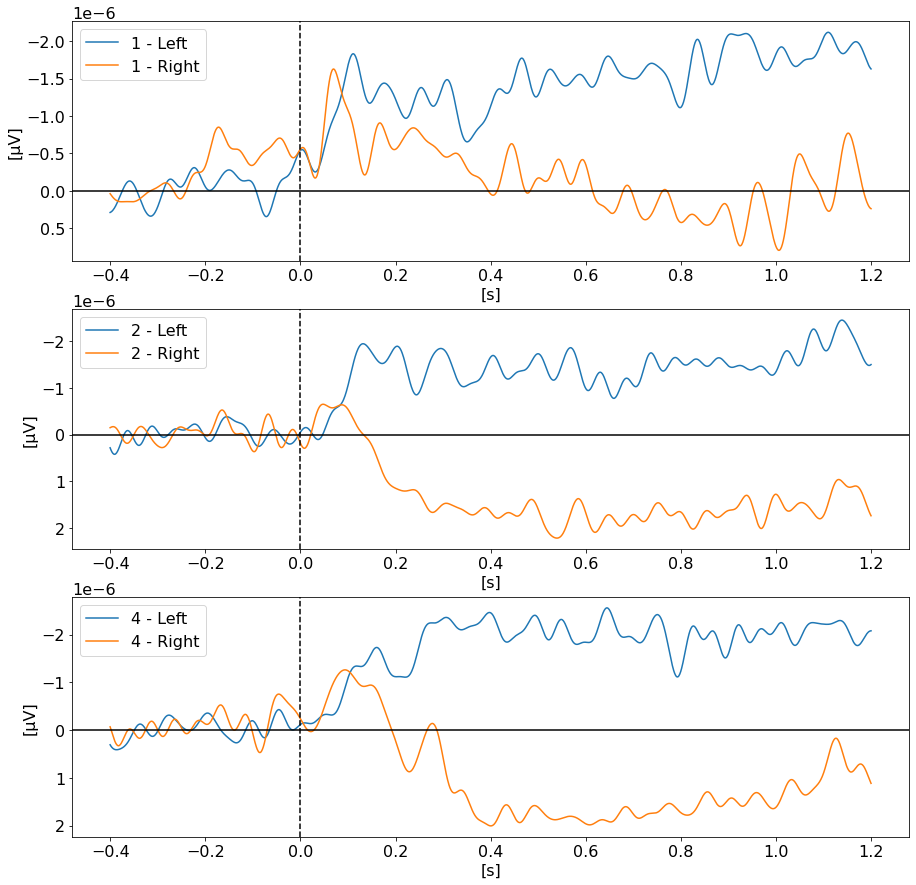

In [5]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(3, 1, figsize=(15,15))

# 2. Plot Figure #1
axs[0].plot(times, cda_all['1']['left'].mean(0), label='1 - Left')
axs[0].plot(times, cda_all['1']['right'].mean(0), label='1 - Right')
axs[0].axvline(x=0, color='k', linestyle='--')
axs[0].axhline(y=0, color='k', linestyle='-')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_ylabel('[μV]')
axs[0].set_xlabel('[s]')

# 2. Plot Figure #2
axs[1].plot(times, cda_all['2']['left'].mean(0), label='2 - Left')
axs[1].plot(times, cda_all['2']['right'].mean(0), label='2 - Right')
axs[1].axvline(x=0, color='k', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_ylabel('[μV]')
axs[1].set_xlabel('[s]')

# 2. Plot Figure #2
axs[2].plot(times, cda_all['4']['left'].mean(0), label='4 - Left')
axs[2].plot(times, cda_all['4']['right'].mean(0), label='4 - Right')
axs[2].axvline(x=0, color='k', linestyle='--')
axs[2].axhline(y=0, color='k', linestyle='-')
axs[2].invert_yaxis()
axs[2].legend()
axs[2].set_ylabel('[μV]')
axs[2].set_xlabel('[s]')

#plt.savefig("./V-2018-Exp1_CDA-reprod.png", dpi=300, format='png')